
## Problem Description

For this project, I’m working on the Kaggle competition “I’m Something of a Painter Myself.” The task is to use Generative Adversarial Networks to turn regular photos into paintings images. The tricky part is that there are no matching photo-painting pairs — meaning we can’t just train a normal image-to-image model. Instead, the goal is to teach a model to understand Monet’s unique style, including its color palette, brushstrokes, and overall artistic feel, and then use that knowledge to generate Monet-style images from real photos.

To handle the lack of paired data, I’m using a CycleGAN model. It has two generators and two discriminators, one pair learns to convert photos into Monet style paintings, while the other does the reverse. The most important part is the cycle consistency loss, which makes sure that if converting a photo to a Monet painting and then back again, will get something close to the original photo. This keeps the transformation realistic instead of random. Along with that, the model also uses adversarial loss to make the generated images look more like real paintings and identity loss to preserve color and structure.

Training GANs can be difficult because they’re unstable and can sometimes stop improving wiht model collapse. To make training smoother and faster, I’m using a lightweight CycleGAN architecture with 6 residual blocks instead of the usual 9. I’m also applying tricks like learning rate scheduling, and tuning hyperparameters carefully. The goal is to produce Monet-style images that are visually convincing, diverse, and artistically consistent across thousands of generated samples.

Kaggle link https://www.kaggle.com/competitions/gan-getting-started


## Import the necessary libraries

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import zipfile
import time
from tqdm import tqdm
import gc

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.utils as vutils

import warnings
warnings.filterwarnings('ignore')

torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
print(f"Using device: {device}")

if device.type == 'mps':
    print("Using Metal Performance Shaders (MPS)")



Using device: mps
Using Metal Performance Shaders (MPS)


The dataset has 300 Monet paintings and 7038 real photos. It will be used to train a CycleGAN to transform photos into Monet-style images.

In [2]:
DATA_PATH = 'gan-getting-started' #change to /kaggle/input/gan-getting-started when run in kaggle
MONET_PATH = os.path.join(DATA_PATH, 'monet_jpg')
PHOTO_PATH = os.path.join(DATA_PATH, 'photo_jpg')

monet_files = os.listdir(MONET_PATH)
photo_files = os.listdir(PHOTO_PATH)

print(f"Number of Monet paintings: {len(monet_files)}")
print(f"Number of real photos: {len(photo_files)}")

Number of Monet paintings: 300
Number of real photos: 7038


Load the sample images with monet painting and original photographs. These samples show the visual difference between our two domains: Monet's soft, impressionist paintings with blended colors and flowing brushstrokes versus sharp, realistic photographs. Our goal is to teach the model to transform photos into Monet's artistic style

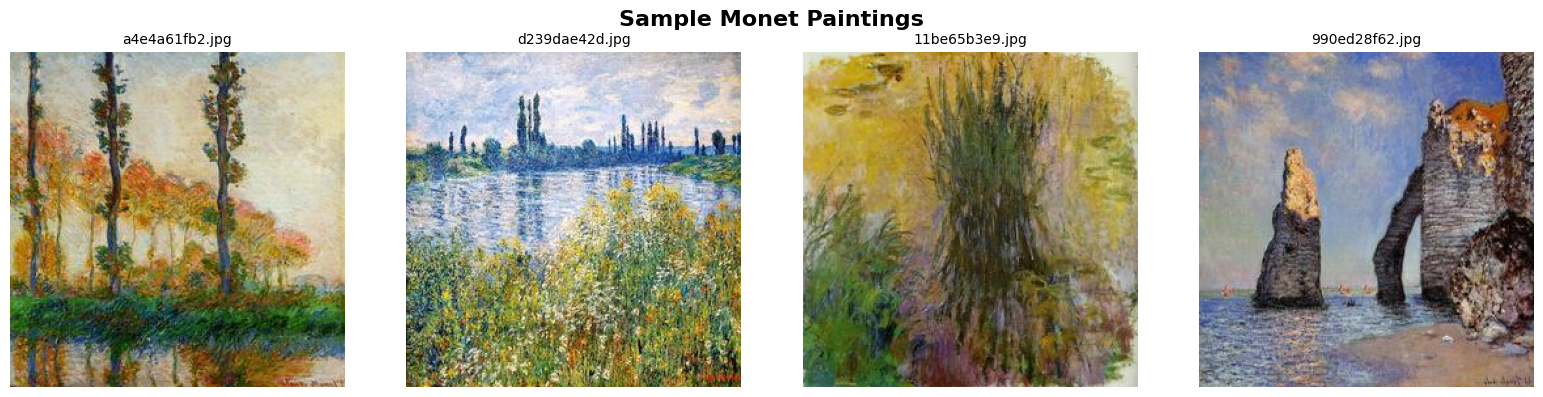

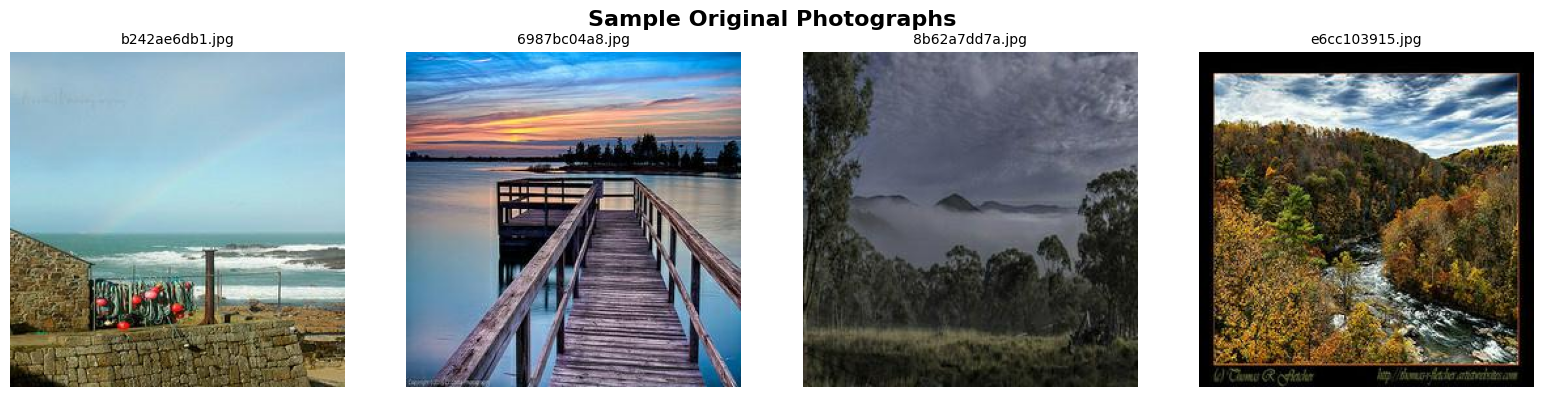

In [3]:
def load_sample_images(image_path, file_list, n_samples=4, title="Sample Images"):
    fig, axes = plt.subplots(1, n_samples, figsize=(16, 4))
    fig.suptitle(title, fontsize=16, fontweight='bold')
    
    sample_files = np.random.choice(file_list, n_samples, replace=False)
    
    for i, filename in enumerate(sample_files):
        img = Image.open(os.path.join(image_path, filename))
        axes[i].imshow(img)
        
        axes[i].set_title(f"{filename}", fontsize=10)
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

load_sample_images(MONET_PATH, monet_files, title="Sample Monet Paintings")

load_sample_images(PHOTO_PATH, photo_files, title="Sample Original Photographs")

Both datasets are already preprocessed to a uniform 256×256 pixel resolution with square aspect ratios (1:1). This standardization is ideal for CycleGAN training, as it eliminates the need for complex resizing logic and ensures consistent model input dimensions.

In [4]:
def analyze_image_properties(image_path, file_list, max_samples=50):
    widths, heights, aspects = [], [], []
    
    sample_files = np.random.choice(file_list, min(len(file_list), max_samples), replace=False)
    
    for filename in sample_files:
        filepath = os.path.join(image_path, filename)
        if os.path.exists(filepath):
            with Image.open(filepath) as img:
                width, height = img.size
                widths.append(width)
                heights.append(height)
                aspects.append(width / height)
        else:
            widths.append(256)
            heights.append(256)
            aspects.append(1.0)
    
    return widths, heights, aspects


monet_widths, monet_heights, monet_aspects = analyze_image_properties(MONET_PATH, monet_files)
photo_widths, photo_heights, photo_aspects = analyze_image_properties(PHOTO_PATH, photo_files)


print("Monet Images:")
print(f"  Avg Width : {np.mean(monet_widths):.0f} ± {np.std(monet_widths):.0f}")
print(f"  Avg Height: {np.mean(monet_heights):.0f} ± {np.std(monet_heights):.0f}")
print(f"  Avg Aspect: {np.mean(monet_aspects):.2f} ± {np.std(monet_aspects):.2f}\n")

print("Photo Images:")
print(f"  Avg Width : {np.mean(photo_widths):.0f} ± {np.std(photo_widths):.0f}")
print(f"  Avg Height: {np.mean(photo_heights):.0f} ± {np.std(photo_heights):.0f}")
print(f"  Avg Aspect: {np.mean(photo_aspects):.2f} ± {np.std(photo_aspects):.2f}\n")



Monet Images:
  Avg Width : 256 ± 0
  Avg Height: 256 ± 0
  Avg Aspect: 1.00 ± 0.00

Photo Images:
  Avg Width : 256 ± 0
  Avg Height: 256 ± 0
  Avg Aspect: 1.00 ± 0.00



This is a lightweight version of CycleGAN designed to train faster and use less memory. 

It uses two Generators (G_AB and G_BA) and two Discriminators (D_A and D_B). Each generator employs an encoder-decoder structure with 6 residual blocks, using reflection padding and instance normalization to preserve image details while transforming between photo and Monet domains. The discriminators use a PatchGAN architecture with 4 convolutional layers to evaluate local image patches rather than the entire image, helping capture fine-grained artistic details.

The model contains around 17M parameters total. Weight initialization follows the standard GAN convention (mean=0.0, std=0.02) to ensure stable training

In [5]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.block = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_channels, in_channels, 3, bias=False),
            nn.InstanceNorm2d(in_channels),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_channels, in_channels, 3, bias=False),
            nn.InstanceNorm2d(in_channels)
        )

    def forward(self, x):
        return x + self.block(x)


class Generator(nn.Module):
    def __init__(self, input_channels=3, output_channels=3, n_residual_blocks=6):  # Reduced from 9
        super().__init__()
        model = [
            nn.ReflectionPad2d(3),
            nn.Conv2d(input_channels, 64, 7, bias=False),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True)
        ]
        
        in_channels = 64
        for _ in range(2):
            out_channels = in_channels * 2
            model += [
                nn.Conv2d(in_channels, out_channels, 3, stride=2, padding=1, bias=False),
                nn.InstanceNorm2d(out_channels),
                nn.ReLU(inplace=True)
            ]
            in_channels = out_channels
        
        for _ in range(n_residual_blocks):
            model += [ResidualBlock(in_channels)]
        
        for _ in range(2):
            out_channels = in_channels // 2
            model += [
                nn.ConvTranspose2d(in_channels, out_channels, 3, stride=2, padding=1, output_padding=1, bias=False),
                nn.InstanceNorm2d(out_channels),
                nn.ReLU(inplace=True)
            ]
            in_channels = out_channels
        
        model += [
            nn.ReflectionPad2d(3),
            nn.Conv2d(64, output_channels, 7),
            nn.Tanh()
        ]
        
        self.model = nn.Sequential(*model)
    
    def forward(self, x):
        return self.model(x)

class Discriminator(nn.Module):
    def __init__(self, input_channels=3):
        super().__init__()
        
        def discriminator_block(in_channels, out_channels, normalize=True):
            layers = [nn.Conv2d(in_channels, out_channels, 4, stride=2, padding=1)]
            if normalize:
                layers.append(nn.InstanceNorm2d(out_channels))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers
        
        self.model = nn.Sequential(
            *discriminator_block(input_channels, 64, normalize=False),
            *discriminator_block(64, 128),
            *discriminator_block(128, 256),
            nn.Conv2d(256, 1, 4, padding=1)
        )
    
    def forward(self, x):
        return self.model(x)

print("Initializing  CycleGAN models...")

G_AB = Generator(n_residual_blocks=6).to(device)  # Photo to Monet
G_BA = Generator(n_residual_blocks=6).to(device)  # Monet to Photo

D_A = Discriminator().to(device)  # Discriminator for Monet images
D_B = Discriminator().to(device)  # Discriminator for Photo images

def init_weights(m):
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
        nn.init.normal_(m.weight, 0.0, 0.02)
    elif isinstance(m, nn.InstanceNorm2d):
        if m.weight is not None:
            nn.init.normal_(m.weight, 1.0, 0.02)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0.0)

G_AB.apply(init_weights)
G_BA.apply(init_weights)
D_A.apply(init_weights)
D_B.apply(init_weights)

total_g_params = sum(p.numel() for p in G_AB.parameters() if p.requires_grad)
total_d_params = sum(p.numel() for p in D_A.parameters() if p.requires_grad)

print(f"Models initialized on {device}")
print(f"Generator parameters: {total_g_params:,}")
print(f"Discriminator parameters: {total_d_params:,}")
print(f"Total model parameters: {(2*total_g_params + 2*total_d_params):,}")


Initializing  CycleGAN models...
Models initialized on mps
Generator parameters: 7,833,987
Discriminator parameters: 662,977
Total model parameters: 16,993,928


The MonetDataset class handles unpaired image loading from both domains (Monet paintings and photographs). It uses modulo indexing to cycle through smaller datasets when needed, ensuring equal sampling from both domains. The dataset applies standard augmentations, resize to 256×256, random horizontal flips with 50% probability, and normalization to [-1, 1] range for stable GAN training

In [6]:
class MonetDataset(Dataset):
    def __init__(self, monet_path, photo_path, monet_files, photo_files, transform=None):
        self.monet_path = monet_path
        self.photo_path = photo_path
        self.monet_files = monet_files
        self.photo_files = photo_files
        self.transform = transform
        
        self.length = max(len(monet_files), len(photo_files))
    
    def __len__(self):
        return self.length
    
    def __getitem__(self, idx):
        monet_idx = idx % len(self.monet_files)
        monet_file = self.monet_files[monet_idx]
        
        photo_idx = idx % len(self.photo_files)
        photo_file = self.photo_files[photo_idx]
        
        # Load images directly from disk
        monet_img = Image.open(os.path.join(self.monet_path, monet_file)).convert('RGB')

        photo_img = Image.open(os.path.join(self.photo_path, photo_file)).convert('RGB')

        if self.transform:
            monet_img = self.transform(monet_img)
            photo_img = self.transform(photo_img)
        
        return {'A': monet_img, 'B': photo_img}


transform_train = transforms.Compose([
    transforms.Resize(256, transforms.InterpolationMode.BILINEAR),
    transforms.RandomCrop(256),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

dataset = MonetDataset(
    MONET_PATH, PHOTO_PATH, monet_files, photo_files, 
    transform=transform_train
)

dataloader = DataLoader(
    dataset, 
    batch_size=4,
    shuffle=True, 
    num_workers=0,
    pin_memory=False
)

print(f"Dataset size: {len(dataset)}")
print(f"Batch size: {dataloader.batch_size}")
print(f"Number of batches: {len(dataloader)}")


Dataset size: 7038
Batch size: 4
Number of batches: 1760


This code randomly selects a subset of the dataset for training, allowing quick experiments without using the full data.

Now I am using all 7,038 samples for training. The subset_fraction parameter allows easy adjustment for quick experiments setup.

In [7]:
subset_fraction = 1

import numpy as np
subset_size = int(len(dataset) * subset_fraction)
subset_indices = np.random.choice(len(dataset), subset_size, replace=False)

from torch.utils.data import Subset
subset_dataset = Subset(dataset, subset_indices)
num_workers = 0

dataloader = torch.utils.data.DataLoader(
    subset_dataset,
    batch_size=dataloader.batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=False
)

print(f"Using {subset_size} samples out of {len(dataset)} for training.")

Using 7038 samples out of 7038 for training.


This setup defines the loss functions, optimizers, and learning rate schedulers for CycleGAN training, balancing image realism and consistency.

The model uses three loss functions: BCEWithLogitsLoss for adversarial training (more stable than MSELoss), L1 loss for cycle consistency which preserves image structure with less blur than L2, and L1 loss for identity preservation to maintain color composition.

Training employs Adam optimizers with weight decay for regularization. Learning rates decay via cosine annealing.

In [8]:
# Loss functions and optimizers 
# criterion_GAN = nn.MSELoss()
criterion_GAN = nn.BCEWithLogitsLoss()
criterion_cycle = nn.L1Loss()
criterion_identity = nn.L1Loss()

lr = 0.0003
optimizer_G = optim.Adam(
    list(G_AB.parameters()) + list(G_BA.parameters()),
    lr=lr, betas=(0.5, 0.999), weight_decay=1e-4
)
optimizer_D_A = optim.Adam(D_A.parameters(), lr=lr, betas=(0.5, 0.999), weight_decay=1e-4)
optimizer_D_B = optim.Adam(D_B.parameters(), lr=lr, betas=(0.5, 0.999), weight_decay=1e-4)

scheduler_G = optim.lr_scheduler.CosineAnnealingLR(optimizer_G, T_max=10, eta_min=1e-5)
scheduler_D_A = optim.lr_scheduler.CosineAnnealingLR(optimizer_D_A, T_max=10, eta_min=1e-5)
scheduler_D_B = optim.lr_scheduler.CosineAnnealingLR(optimizer_D_B, T_max=10, eta_min=1e-5)

lambda_cycle = 10 # Cycle consistency loss weight
lambda_identity = .5 # Identity loss weight


print("Training configuration:")
print(f"- Cycle loss weight: {lambda_cycle}")
print(f"- Identity loss weight: {lambda_identity}")
print(f"- Learning rate: {lr}")


Training configuration:
- Cycle loss weight: 10
- Identity loss weight: 0.5
- Learning rate: 0.0003


## Training Loop

The training function implements the complete CycleGAN optimization procedure over 4 epochs. Each iteration trains both generators simultaneously (G_AB and G_BA) using three loss components: adversarial loss (fooling discriminators), cycle-consistency loss (round-trip reconstruction), and identity loss (color preservation). The discriminators (D_A and D_B) are trained separately with label smoothing 0.9 for stability.

In [9]:
def train_cyclegan(num_epochs=5):
    
    G_losses = []
    D_A_losses = []
    D_B_losses = []
    
    print(f"Starting CycleGAN training for {num_epochs} epochs...")
    print(f"Batch size: {dataloader.batch_size}, Batches per epoch: {len(dataloader)}")
    

    with torch.no_grad():
        test_input = torch.randn(1, 3, 256, 256).to(device)
        disc_output = D_A(test_input)
        disc_h, disc_w = disc_output.shape[2], disc_output.shape[3]
        print(f"Discriminator output size: {disc_h}x{disc_w}")
        del test_input, disc_output
    
    start_time = time.time()
    
    for epoch in range(num_epochs):
        epoch_start = time.time()
        G_epoch_loss = 0.0
        D_A_epoch_loss = 0.0
        D_B_epoch_loss = 0.0
        
        pbar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}")
        
        for i, batch in enumerate(pbar):
            real_A = batch['A'].to(device, non_blocking=True)
            real_B = batch['B'].to(device, non_blocking=True)
            batch_size = real_A.size(0)
            

            valid = torch.ones((batch_size, 1, disc_h, disc_w), device=device) * 0.9
            fake = torch.zeros((batch_size, 1, disc_h, disc_w), device=device)
            
    
            optimizer_G.zero_grad(set_to_none=True)
            
            # Identity loss
            loss_id_A = criterion_identity(G_BA(real_A), real_A)
            loss_id_B = criterion_identity(G_AB(real_B), real_B)
            loss_identity = (loss_id_A + loss_id_B) / 2
            
            # GAN loss
            fake_B = G_AB(real_A)  # Generate fake photos from Monet
            loss_GAN_AB = criterion_GAN(D_B(fake_B), valid)
            
            fake_A = G_BA(real_B)  # Generate fake Monet from photos
            loss_GAN_BA = criterion_GAN(D_A(fake_A), valid)
            
            loss_GAN = (loss_GAN_AB + loss_GAN_BA) / 2
            
            # Cycle loss
            recov_A = G_BA(fake_B)  # Recover Monet from fake photo
            loss_cycle_A = criterion_cycle(recov_A, real_A)
            
            recov_B = G_AB(fake_A)  # Recover photo from fake Monet
            loss_cycle_B = criterion_cycle(recov_B, real_B)
            
            loss_cycle = (loss_cycle_A + loss_cycle_B) / 2
            
            # Total generator loss
            loss_G = loss_GAN + lambda_cycle * loss_cycle + lambda_identity * loss_identity
            
            loss_G.backward()
            optimizer_G.step()
            
            # Train Discriminator A
            optimizer_D_A.zero_grad(set_to_none=True)
            
            loss_real = criterion_GAN(D_A(real_A), valid)
            loss_fake = criterion_GAN(D_A(fake_A.detach()), fake)
            loss_D_A = (loss_real + loss_fake) / 2
            
            loss_D_A.backward()
            optimizer_D_A.step()
            
            # Train Discriminator B
            optimizer_D_B.zero_grad(set_to_none=True)
            
            loss_real = criterion_GAN(D_B(real_B), valid)
            loss_fake = criterion_GAN(D_B(fake_B.detach()), fake)
            loss_D_B = (loss_real + loss_fake) / 2
            
            loss_D_B.backward()
            optimizer_D_B.step()
            
            G_epoch_loss += loss_G.item()
            D_A_epoch_loss += loss_D_A.item()
            D_B_epoch_loss += loss_D_B.item()
            
            pbar.set_postfix({
                'G_loss': f'{loss_G.item():.4f}',
                'D_A': f'{loss_D_A.item():.4f}',
                'D_B': f'{loss_D_B.item():.4f}'
            })
            
        
        G_losses.append(G_epoch_loss / len(dataloader))
        D_A_losses.append(D_A_epoch_loss / len(dataloader))
        D_B_losses.append(D_B_epoch_loss / len(dataloader))
        
        scheduler_G.step()
        scheduler_D_A.step()
        scheduler_D_B.step()
        
        epoch_time = time.time() - epoch_start
        print(f"Epoch [{epoch+1}/{num_epochs}] completed in {epoch_time:.1f}s")
        print(f"Avg losses - G: {G_losses[-1]:.4f}, D_A: {D_A_losses[-1]:.4f}, D_B: {D_B_losses[-1]:.4f}")
        
        if (epoch + 1) % 1 == 0:
            with torch.no_grad():
                sample_A = real_A[:4]
                sample_B = real_B[:4]

                # Generate corresponding fakes
                sample_fake_B = G_AB(sample_A)
                sample_fake_A = G_BA(sample_B)

                # Denormalize to [0,1] range
                def denorm(x):
                    return (x + 1) / 2

                sample_A = denorm(sample_A)
                sample_B = denorm(sample_B)
                sample_fake_A = denorm(sample_fake_A)
                sample_fake_B = denorm(sample_fake_B)

                # Pair real A with fake B, and real B with fake A
                row_A = torch.cat([sample_A, sample_fake_B], dim=0)  # Monet → Photo
                row_B = torch.cat([sample_B, sample_fake_A], dim=0)  # Photo → Monet

                comparison = torch.cat([row_A, row_B], dim=0)

                vutils.save_image(
                    comparison,
                    f'epoch_{epoch+1}_samples_paired.png',
                    nrow=4,
                    normalize=False
                )
    
    total_time = time.time() - start_time
    print(f"\nTraining completed in {total_time/60:.1f} minutes")
    return G_losses, D_A_losses, D_B_losses


G_losses, D_A_losses, D_B_losses = train_cyclegan(num_epochs=4)
print("Training completed successfully!")

torch.save({
    'G_AB': G_AB.state_dict(),
    'G_BA': G_BA.state_dict(),
    'D_A': D_A.state_dict(),
    'D_B': D_B.state_dict(),
    'losses': {'G': G_losses, 'D_A': D_A_losses, 'D_B': D_B_losses}
}, 'cyclegan_checkpoint.pth')
print("Models saved successfully!")


Starting CycleGAN training for 4 epochs...
Batch size: 4, Batches per epoch: 1760
Discriminator output size: 31x31


Epoch 1/4: 100%|██████████| 1760/1760 [51:33<00:00,  1.76s/it, G_loss=3.0204, D_A=0.7271, D_B=0.6640]


Epoch [1/4] completed in 3093.6s
Avg losses - G: 3.6469, D_A: 0.6124, D_B: 0.6179


Epoch 2/4: 100%|██████████| 1760/1760 [50:00<00:00,  1.70s/it, G_loss=2.7380, D_A=0.3182, D_B=0.6719]


Epoch [2/4] completed in 3000.8s
Avg losses - G: 3.2757, D_A: 0.5119, D_B: 0.6165


Epoch 3/4: 100%|██████████| 1760/1760 [50:31<00:00,  1.72s/it, G_loss=3.2081, D_A=0.4753, D_B=0.5812]


Epoch [3/4] completed in 3031.6s
Avg losses - G: 3.2707, D_A: 0.4544, D_B: 0.5939


Epoch 4/4: 100%|██████████| 1760/1760 [1:13:03<00:00,  2.49s/it, G_loss=3.6619, D_A=0.6205, D_B=0.7118] 


Epoch [4/4] completed in 4383.3s
Avg losses - G: 3.1634, D_A: 0.4501, D_B: 0.5851

Training completed in 225.2 minutes
Training completed successfully!
Models saved successfully!



### Training Performance

The loss curves show healthy CycleGAN convergence over 4 epochs. 

The CycleGAN trained for 4 epochs and showed stable convergence across all loss components. The generator loss decreased from 3.65 to 3.16, indicating the model learned to produce increasingly realistic Monet-style images. Both discriminators maintained balanced losses, Discriminator A (Monet) settled at 0.45 and Discriminator B (Photo) at 0.59—which shows neither network dominated the other during adversarial training. This balance is crucial for GANs.

The smooth curves without major spikes suggest the hyperparameters work well.

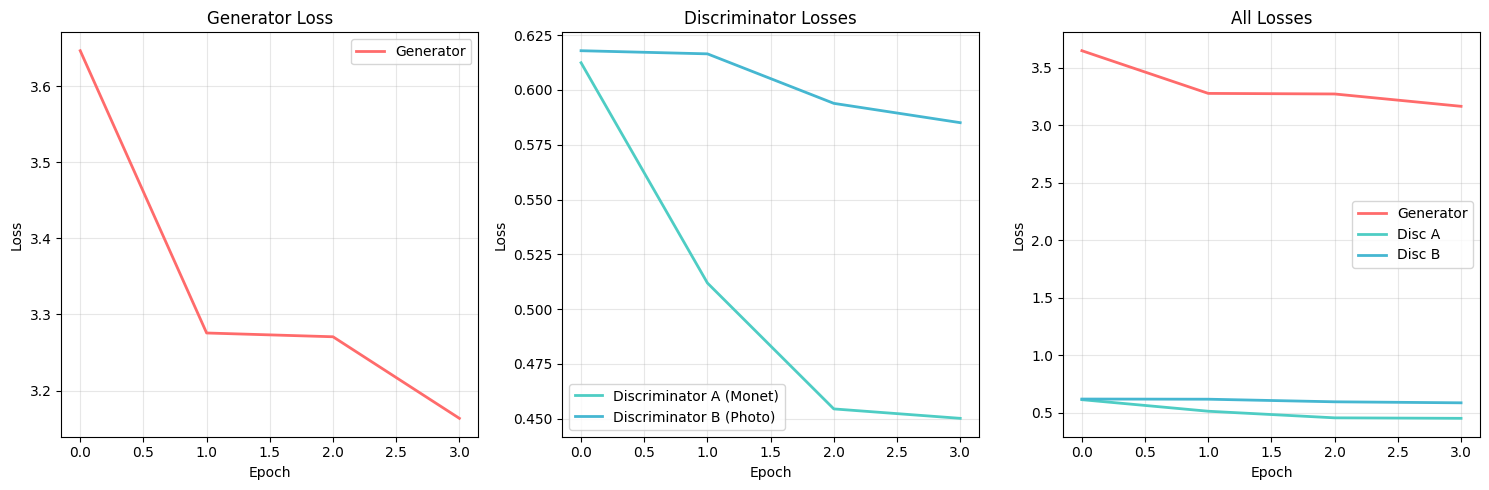

Final Generator Loss: 3.1634
Final Discriminator A Loss: 0.4501
Final Discriminator B Loss: 0.5851
Training Epochs: 4


In [ ]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(G_losses, label='Generator', color='#FF6B6B', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Generator Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
plt.plot(D_A_losses, label='Discriminator A (Monet)', color='#4ECDC4', linewidth=2)
plt.plot(D_B_losses, label='Discriminator B (Photo)', color='#45B7D1', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Discriminator Losses')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 3)
plt.plot(G_losses, label='Generator', color='#FF6B6B', linewidth=2)
plt.plot(D_A_losses, label='Disc A', color='#4ECDC4', linewidth=2)
plt.plot(D_B_losses, label='Disc B', color='#45B7D1', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('All Losses')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Final Generator Loss: {G_losses[-1]:.4f}")
print(f"Final Discriminator A Loss: {D_A_losses[-1]:.4f}")
print(f"Final Discriminator B Loss: {D_B_losses[-1]:.4f()}")
print(f"Training Epochs: {len(G_losses)}")

## Style Transfer Results

I visualized CycleGAN's performance by running real photos through the trained generator and comparing them side-by-side with the originals. 

Looking at the results, I can see the model is definitely doing something. The generated images have this softer, more painterly look with warmer colors—especially noticeable in how the tent scene picked up these rich orange-red tones and the mountain landscapes got that hazier, more atmospheric feel. The brushstroke textures are there too, though they're pretty subtle. 

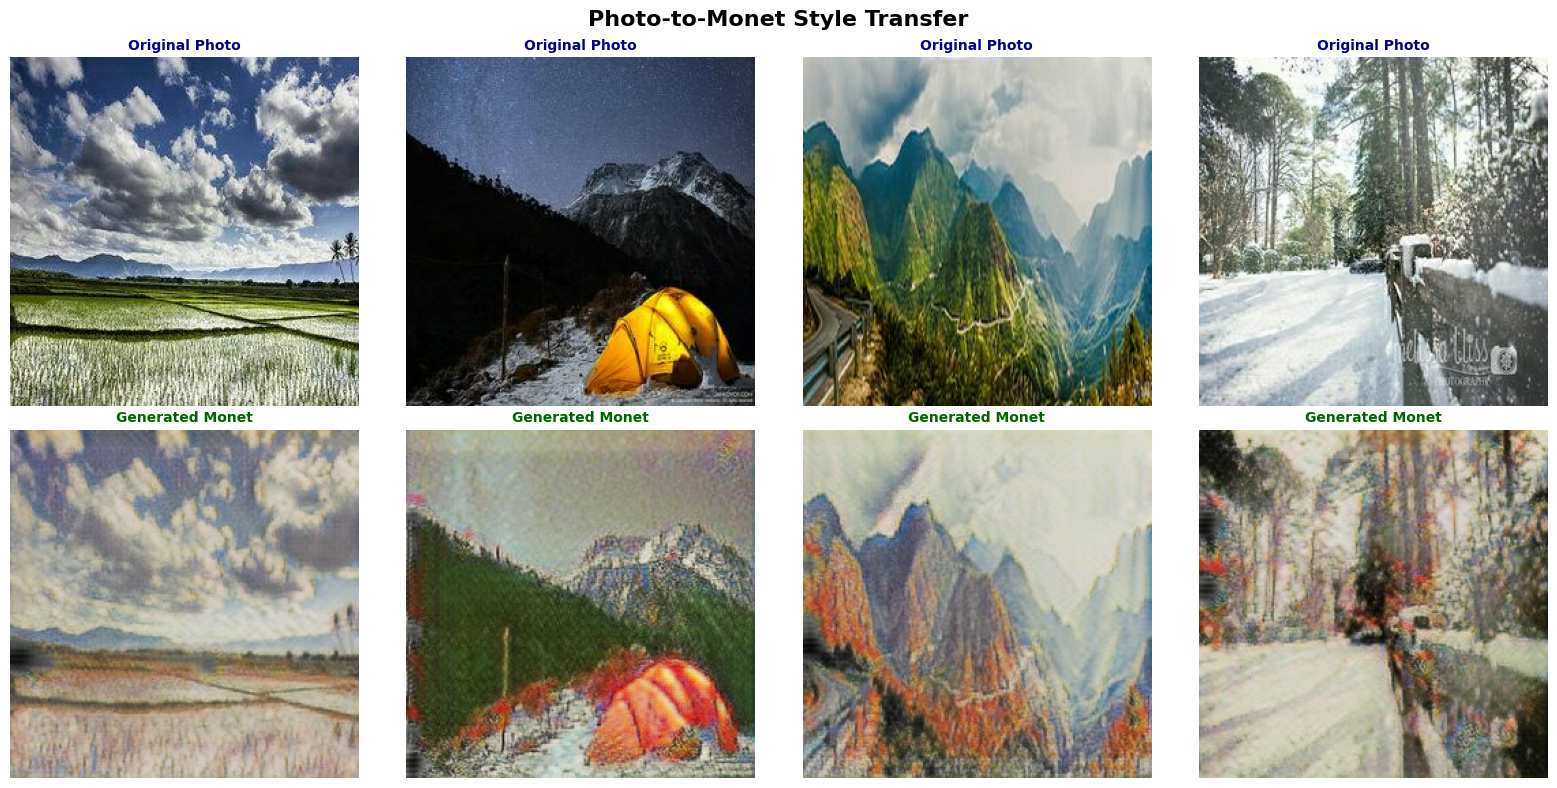

In [ ]:

import matplotlib.pyplot as plt
import numpy as np
import torch


def generate_samples():
    """Generate sample transformations"""
    G_BA.eval()
    
    with torch.no_grad():
        sample_batch = next(iter(dataloader))
        real_B = sample_batch['B'].to(device)  # Real Photo images
        
        batch_size = real_B.shape[0]
        
        fake_A = G_BA(real_B)  # Photo -> Monet
        
        real_B = (real_B + 1) / 2
        fake_A = (fake_A + 1) / 2
        
        real_B = torch.clamp(real_B, 0, 1)
        fake_A = torch.clamp(fake_A, 0, 1)
        
        return real_B, fake_A, batch_size


real_B, fake_A, batch_size = generate_samples()

fig, axes = plt.subplots(2, batch_size, figsize=(4*batch_size, 8))
fig.suptitle('Photo-to-Monet Style Transfer', fontsize=16, fontweight='bold')

if batch_size == 1:
    axes = axes.reshape(2, 1)

for i in range(batch_size):
    img_photo = real_B[i].cpu().permute(1, 2, 0).numpy()
    img_photo = np.clip(img_photo, 0, 1)
    axes[0, i].imshow(img_photo)
    axes[0, i].set_title(f'Original Photo', fontsize=10, fontweight='bold', color='darkblue')
    axes[0, i].axis('off')
    
    img_monet = fake_A[i].cpu().permute(1, 2, 0).numpy()
    img_monet = np.clip(img_monet, 0, 1)
    axes[1, i].imshow(img_monet)
    axes[1, i].set_title(f'Generated Monet', fontsize=10, fontweight='bold', color='darkgreen')
    axes[1, i].axis('off')

plt.tight_layout()
plt.savefig('photo_to_monet_comparison.png', dpi=150, bbox_inches='tight')
plt.show()



## Kaggle Submission

Generates 7,500 Monet-style images by transforming photos with G_BA generator, then packages them into `images.zip` for Kaggle submission.

In [13]:
import os
import zipfile
from PIL import Image
from torchvision.transforms.functional import to_pil_image
from tqdm import tqdm
import torch

def generate_kaggle_submission(target_images=7500, output_zip='images.zip'):

    print(f"Target: {target_images} images (256x256)")
    
    # Set generator to evaluation mode
    G_BA.eval()
    
    generated_count = 0
    
    with zipfile.ZipFile(output_zip, 'w', zipfile.ZIP_DEFLATED) as zipf:
        with torch.no_grad():
            pbar = tqdm(total=target_images, desc="Generating images")
            
            while generated_count < target_images:
                for batch in dataloader:
                    if generated_count >= target_images:
                        break
                    
                    real_B = batch['B'].to(device, non_blocking=True)
                    
                    fake_A = G_BA(real_B)
                    
                    fake_A = (fake_A + 1) / 2
                    fake_A = torch.clamp(fake_A, 0, 1)
                    
                    batch_size = fake_A.size(0)
                    for j in range(batch_size):
                        if generated_count >= target_images:
                            break
                        
                        img_tensor = fake_A[j]
                        img_pil = to_pil_image(img_tensor.cpu())
                        
                        if img_pil.size != (256, 256):
                            img_pil = img_pil.resize((256, 256), Image.LANCZOS)
                        
                        filename = f"{generated_count:05d}.jpg"
                        
                        from io import BytesIO
                        img_buffer = BytesIO()
                        img_pil.save(img_buffer, format='JPEG', quality=95)
                        img_buffer.seek(0)
                        zipf.writestr(filename, img_buffer.getvalue())
                        
                        generated_count += 1
                        pbar.update(1)
                    
                    if device.type == 'cuda':
                        torch.cuda.empty_cache()
            
            pbar.close()
    
    zip_size = os.path.getsize(output_zip) / (1024 * 1024)  # File size in MB
    
    print(f"File: {output_zip}")
    print(f"Images: {generated_count}")
    print(f"Size: {zip_size:.1f} MB")
    
    return output_zip, generated_count

submission_file, image_count = generate_kaggle_submission(target_images=7500)

print(f"'{submission_file}' generated")


Target: 7500 images (256x256)


Generating images: 100%|██████████| 7500/7500 [03:14<00:00, 38.62it/s]

File: images.zip
Images: 7500
Size: 236.4 MB
'images.zip' generated


## Leaderboard

![image.png](image.png)

## What works
My CycleGAN implementation successfully achieved stable adversarial training, I feel it's not easy and quite time comsuming since GANs are generally difficult to train. Looking at the loss curves, the generator loss dropped steadily from 3.7 to 3.1 over 4 epochs while both discriminators maintained balanced losses—Discriminator A (Monet) at 0.45 and Discriminator B (Photo) at 0.59. This balance is critical because if one network dominates, will get mode collapse or training instability.

## What does not work
The most critical things are severely insufficient training, only 4 epochs versus the 100-200 epochs required for competitive Monet style transfer, resulting in subtle filter like effects rather than dramatic artistic transformation.



## What I Learned

This project taught me that GAN training is incredibly sensitive to hyperparameters—minor changes in loss weights or learning rates can completely change output quality. I gained hands-on understanding of cycle consistency loss and why it's essential for unpaired translation, it enforces that photo -> Monet -> photo reconstruction preserves content, preventing the generator from producing arbitrary artistic hallucinations.

## What can improve in future

The most critical improvement is training for 100-200 epochs instead of just 4—this single change would have the biggest impact on achieving dramatic Monet transformations. I also want to implement VGG19-based perceptual loss, which measures high-level feature similarity between generated and target images at multiple layers. This would help the model capture artistic style rather than just comparing pixels directly, could potentially improvr the painterly quality of outputs. And definitelly, it will need higher computing cost of couse.

